In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import pandas as pd
import time
from igraph import *
import csv

In [2]:
# Generate Graph , nodes=10, edges=30 and export to csv
G = Graph.Erdos_Renyi(n=10,m=30,directed=True)

# Plot Graph
G.es["color"], G.vs["color"], G.vs["label"] = "#B3CDE3", "#FBB4AE", ""
plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))

a=G.get_edgelist()

with open('a.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    #write.writerow(fields)
    write.writerows(a)

In [3]:
#Read csv as Graph object

df=pd.read_csv("a.csv", header=None)

In [4]:
df

,0,1
0,0,1
1,0,4
2,0,6
3,0,8
4,1,5
5,2,0
6,2,9
7,3,1
8,3,5
9,3,8


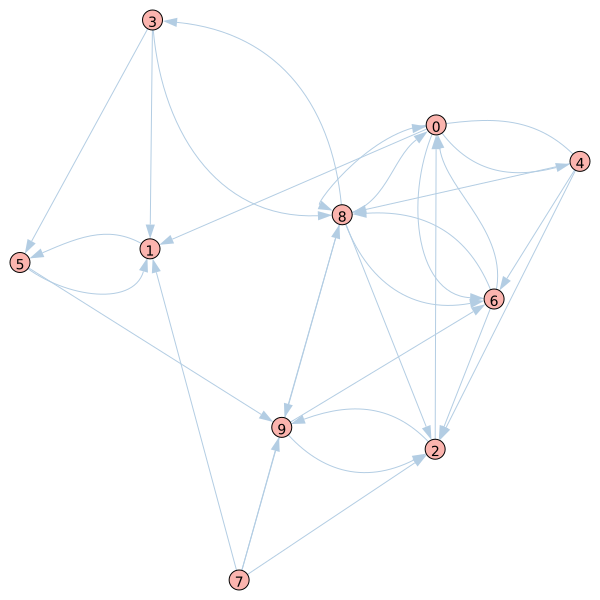

In [5]:
source=df[0]
s=list(source)

target=df[1]
t=target.tolist()

g1 = Graph(directed=True)
g1.add_vertices(range(10))
g1.add_edges(zip(s,t))

# Plot graph
g1.vs["label"], g1.es["color"], g1.vs["color"] = range(10), "#B3CDE3", "#FBB4AE"
#png("my_plot.png", 600, 600)
#dev.off()
plot(g1,bbox = (200,200),margin = 20,layout = g1.layout("kk"),)
plot(g1, "g1.png", dpi=300)

In [14]:
#convert df by adding compatibility factor

df['compf'] = np.random.randint(0,2, size=len(df))

In [15]:
df

,0,1,compf
0,0,1,0
1,0,4,0
2,0,6,0
3,0,8,1
4,1,5,1
5,2,0,0
6,2,9,1
7,3,1,1
8,3,5,1
9,3,8,1


In [16]:
#removing entries where compatibility = 0
df1= df[df['compf'] != 0]

In [17]:
df1

,0,1,compf
3,0,8,1
4,1,5,1
6,2,9,1
7,3,1,1
8,3,5,1
9,3,8,1
11,4,2,1
12,4,6,1
13,4,8,1
14,5,1,1


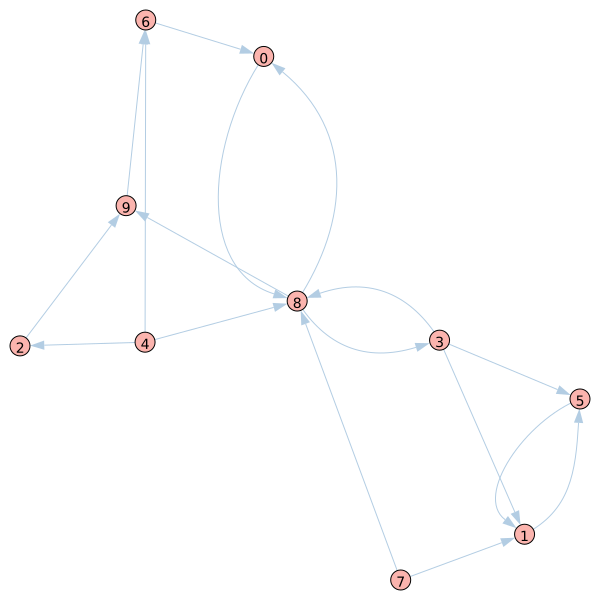

In [18]:
#regenerating graph

source=df1[0]
s=list(source)

target=df1[1]
t=target.tolist()

g2 = Graph(directed=True)
g2.add_vertices(range(10))
g2.add_edges(zip(s,t))

# Plot graph
g2.vs["label"], g2.es["color"], g2.vs["color"] = range(10), "#B3CDE3", "#FBB4AE"
#png("my_plot.png", 600, 600)
#dev.off()
plot(g2,bbox = (200,200),margin = 20,layout = g2.layout("kk"),)
plot(g2, "g1_modified.png", dpi=300)

In [19]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))


In [20]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)


In [21]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)


In [22]:
# Run algorithms with unmodified graph
celf_output1   = celf(g1,2,p = 0.1,mc = 1000)
greedy_output1 = greedy(g1,2,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output1[0]))
print("greedy output: " + str(greedy_output1[0]))


celf output:   [4, 7]
greedy output: [4, 7]


In [23]:
celf_output1

([4, 7], [2.133, 3.226], [0.7126021385192871, 1.8113327026367188], [10, 10])

In [24]:
greedy_output1

([4, 7], [2.133, 3.226], [0.7675602436065674, 2.175267457962036])

In [25]:
# Run algorithms
celf_output2   = celf(g2,2,p = 0.1,mc = 1000)
greedy_output2 = greedy(g2,2,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output2[0]))
print("greedy output: " + str(greedy_output2[0]))


celf output:   [4, 7]
greedy output: [4, 7]


In [26]:
celf_output2

([4, 7], [1.874, 3.31], [0.5786795616149902, 0.9934718608856201], [10, 4])

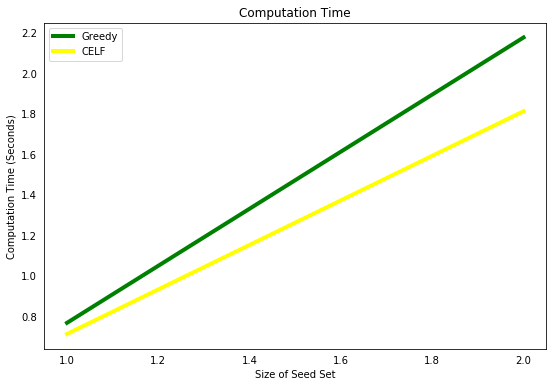

In [27]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output1[2])+1),greedy_output1[2],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[2])+1),celf_output1[2],label="CELF",color="yellow")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);


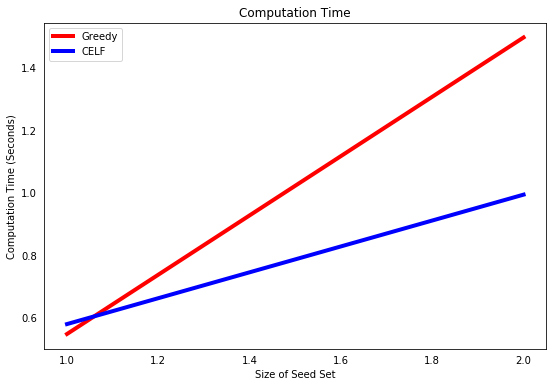

In [28]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output2[2])+1),greedy_output2[2],label="Greedy",color="red")
plt.plot(range(1,len(celf_output2[2])+1),celf_output2[2],label="CELF",color="blue")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

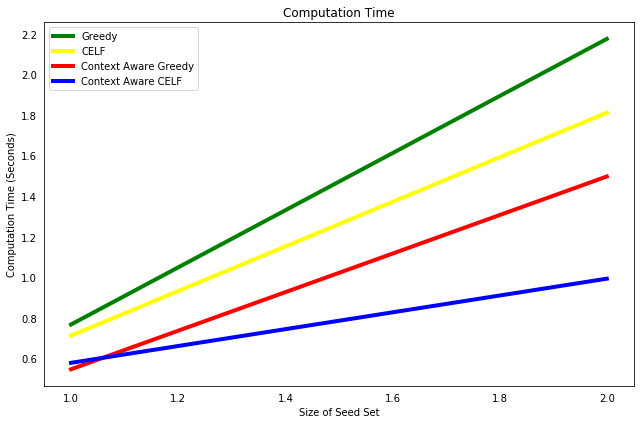

In [34]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output1[2])+1),greedy_output1[2],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[2])+1),celf_output1[2],label="CELF",color="yellow")
plt.plot(range(1,len(greedy_output2[2])+1),greedy_output2[2],label="Context Aware Greedy",color="red")
plt.plot(range(1,len(celf_output2[2])+1),celf_output2[2],label="Context Aware CELF",color="blue")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);
plt.tight_layout()
plt.savefig("g1i.jpg", dpi=300)

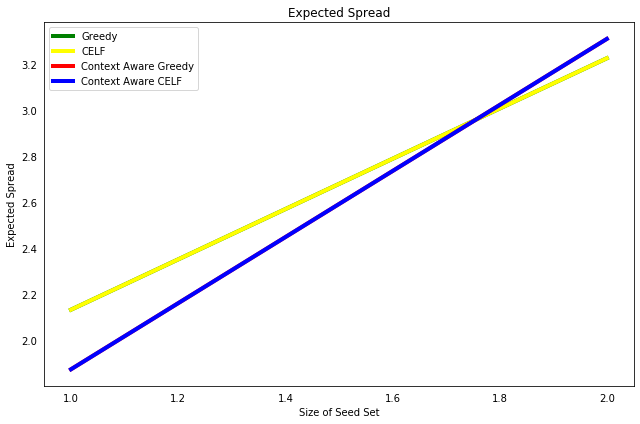

In [36]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output1[1])+1),greedy_output1[1],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[1])+1),celf_output1[1],label="CELF",color="yellow")
plt.plot(range(1,len(greedy_output2[1])+1),greedy_output2[1],label="Context Aware Greedy",color="red")
plt.plot(range(1,len(celf_output2[1])+1),celf_output2[1],label="Context Aware CELF",color="blue")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);
plt.tight_layout()
plt.savefig("g1ii.jpg", dpi=300)
